train autoencoder using 1DCNN roi finder

In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from PyPDF2 import PdfMerger
import os

2023-04-29 17:23:53.488906: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 17:23:54.386411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
wireplane = "U"
np.random.seed(33)
path = 'processed_data/'

In [6]:
def load_data(path, wireplane):
    x_train = np.load(path+'x_train_' + wireplane + '.npy')
    x_test = np.load(path+'x_test_' + wireplane + '.npy')
    y_train = np.load(path+'y_train_AE_' + wireplane + '.npy')
    y_test = np.load(path+'y_test_AE_' + wireplane + '.npy')
    
    #split train and valid sets (40k train 10k valid) 
    x_train, x_valid, y_train, y_valid = train_test_split(
        x_train, y_train, test_size=0.2, shuffle=False
    )
    
    mean = x_train.mean()
    std = x_train.std()

    x_train_scaled = (x_train-mean)/std
    x_test_scaled = (x_test-mean)/std
    x_valid_scaled = (x_valid-mean)/std
    
    y_train_scaled = (y_train-mean)/std
    y_test_scaled = (y_test-mean)/std
    y_valid_scaled = (y_valid-mean)/std

    return x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, x_valid_scaled, y_valid_scaled, mean, std

In [7]:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, x_valid_scaled, y_valid_scaled, mean, std = load_data(path, wireplane)

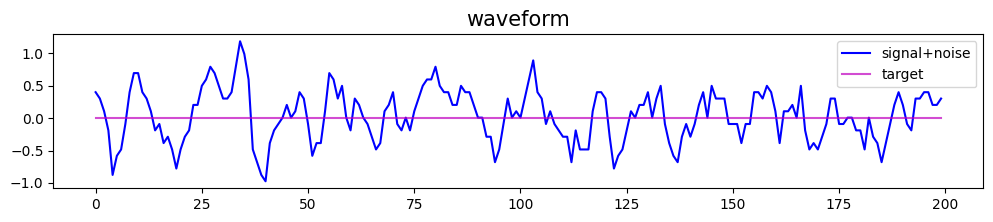

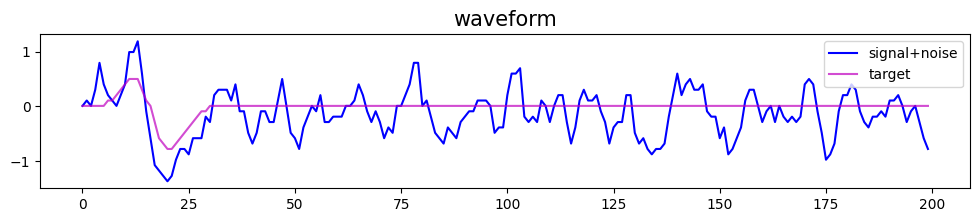

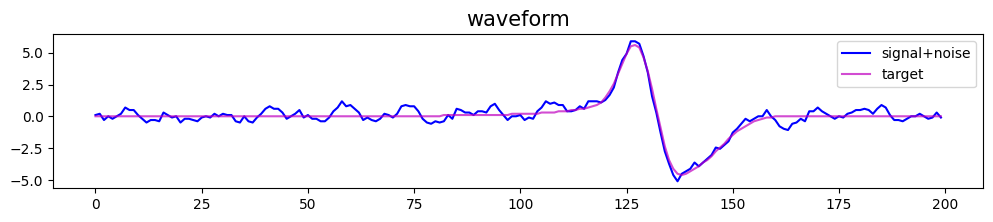

In [10]:
for idx in range(6,9):
    fig, (ax1) = plt.subplots(figsize=(12, 2), facecolor='white')
    ax1.plot(x_train_scaled[idx],color='blue', label='signal+noise')
    ax1.plot(y_train_scaled[idx],color='m',alpha=0.7, label='target')
    ax1.set_title("waveform", fontsize=15)
    ax1.legend()

    plt.show()

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense,Flatten, AveragePooling1D
from tensorflow.keras.layers import Input,  UpSampling1D
from tensorflow.keras.models import Model
#from keras import backend as K

In [13]:
from tensorflow.keras.models import load_model
model = load_model('ROI_models/model_' + wireplane + 'plane_nu_ROI.h5')

2023-04-29 17:25:41.420651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-29 17:25:41.532193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-29 17:25:41.532257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-29 17:25:41.534356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-29 17:25:41.534409: I tensorflow/compile

In [14]:
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 conv1d
1 max_pooling1d
2 conv1d_1
3 max_pooling1d_1
4 dropout
5 conv1d_2
6 global_max_pooling1d
7 dropout_1
8 flatten
9 wavrec_out


In [15]:
time_periods = 200
input_wave = Input(shape=(x_train_scaled.shape[1], 1)) 
x = Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", weights=model.layers[0].get_weights() , input_shape=(time_periods,1))(input_wave)
x = MaxPooling1D(pool_size=2)(x)
 
#second convolutional block
x = Conv1D(filters=32, kernel_size=5, strides=2, weights=model.layers[2].get_weights(), activation = "relu", )(x)
x = MaxPooling1D(pool_size=2)(x)

encoded = Conv1D(filters=64, kernel_size=9, weights=model.layers[5].get_weights(), activation = "relu")(x)


x = Conv1D(filters=64, kernel_size=9, padding = "same", activation = "relu")(encoded)
x = UpSampling1D(4)(x)

x = Conv1D(filters=32, kernel_size=5, padding = "same", activation = "relu")(x)
x = UpSampling1D(3)(x)

x = Conv1D(filters=16, kernel_size=3,  activation = "relu")(x)
x = UpSampling1D(6)(x)

decoded = Conv1D(filters=1, kernel_size=5,  activation = "linear")(x)



autoencoder = Model(input_wave, decoded)

In [16]:
for i,layer in enumerate(autoencoder.layers):                                      
  print(i,layer.name)

0 input_1
1 conv1d
2 max_pooling1d
3 conv1d_1
4 max_pooling1d_1
5 conv1d_2
6 conv1d_3
7 up_sampling1d
8 conv1d_4
9 up_sampling1d_1
10 conv1d_5
11 up_sampling1d_2
12 conv1d_6


In [17]:
# see what happens when we unfreeze more layers of the 1dcnn
for layer in autoencoder.layers[:6]:                                               
    layer.trainable=False                                                          
for layer in autoencoder.layers[6:]:                                               
    layer.trainable=True                                                           
autoencoder.compile(optimizer='adam', loss='mse')

In [18]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 99, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             18496 

In [19]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [20]:
batch_size_ = 128

In [21]:
%%time
history = autoencoder.fit(x_train_scaled,                                                              
            y_train_scaled,                                                            
            batch_size=batch_size_,                                              
            epochs=100,                                                      
            callbacks= [earlystop], #[NewCallback(alpha)], # callbacks=callbacks_list,
            validation_data=(x_valid_scaled, y_valid_scaled),                                                                       
            verbose=1)

Epoch 1/100


2023-04-29 17:25:55.655227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-29 17:25:56.774060: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-29 17:25:57.169082: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fd1e9f7aa50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-29 17:25:57.169118: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-04-29 17:25:57.191644: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-29 17:25:57.437075: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-29 17:25:57.501583: I ./tensorflow/compiler/jit/device_comp

625/625 [==============================] - 9s 7ms/step - loss: 0.2738 - val_loss: 0.1578
Epoch 2/100
625/625 [==============================] - 4s 6ms/step - loss: 0.1358 - val_loss: 0.1296
Epoch 3/100
625/625 [==============================] - 4s 6ms/step - loss: 0.1085 - val_loss: 0.1003
Epoch 4/100
625/625 [==============================] - 4s 6ms/step - loss: 0.0942 - val_loss: 0.0897
Epoch 5/100
625/625 [==============================] - 4s 6ms/step - loss: 0.0835 - val_loss: 0.0773
Epoch 6/100
625/625 [==============================] - 4s 6ms/step - loss: 0.0764 - val_loss: 0.0895
Epoch 7/100
625/625 [==============================] - 3s 6ms/step - loss: 0.0724 - val_loss: 0.0731
Epoch 8/100
625/625 [==============================] - 4s 6ms/step - loss: 0.0719 - val_loss: 0.0729
Epoch 9/100
625/625 [==============================] - 4s 6ms/step - loss: 0.0680 - val_loss: 0.0648
Epoch 10/100
625/625 [==============================] - 4s 6ms/step - loss: 0.0651 - val_loss: 0.0692
E

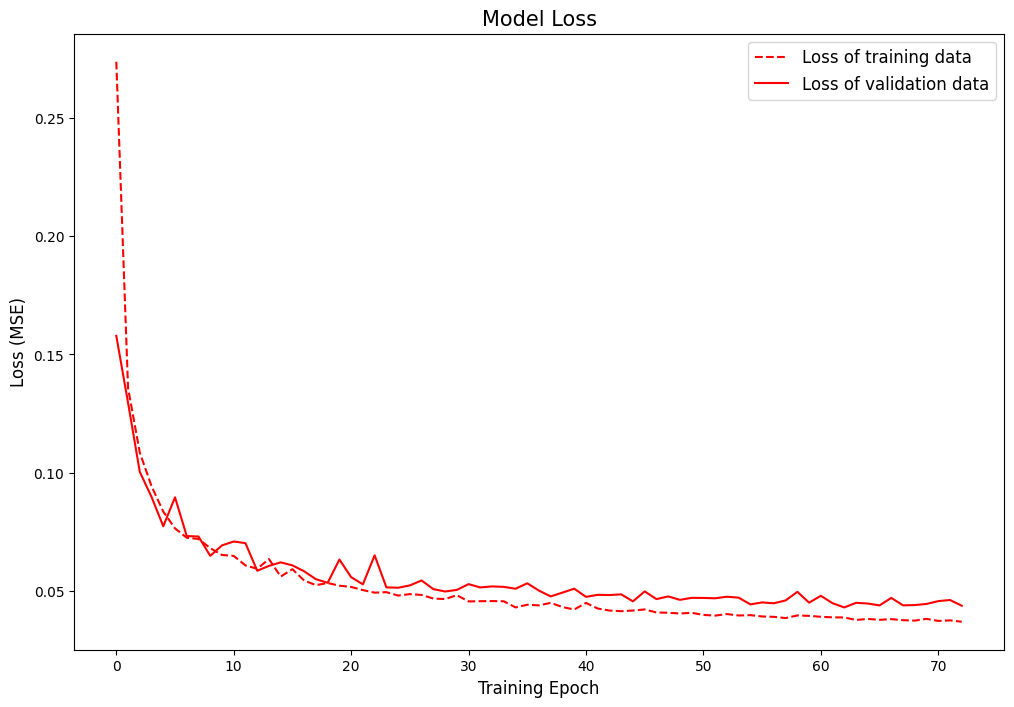

In [22]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['loss'], "r--", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "r", label="Loss of validation data", antialiased=True)
plt.title('Model Loss',fontsize=15)                                            
plt.ylabel('Loss (MSE)', fontsize=12)                                                 
plt.xlabel('Training Epoch', fontsize=12)                                                                                                                       
plt.legend(fontsize=12)                                                                    
plt.show()     

In [23]:
#del x_train

import gc
gc.collect()

5328

In [24]:
autoencoder.save('./AutoEncoder/results/U/models/model_AE_'+str(batch_size_)+'_mse' + wireplane + 'plane_nu.h5')

In [25]:
autoencoder.evaluate(x_test_scaled, y_test_scaled, batch_size=4096)

25/25 [==============================] - 1s 12ms/step - loss: 0.0421


0.042116742581129074

In [26]:
def custom_mse2(y_true, y_pred):

    return -1

In [28]:
%%time
predictions128 = autoencoder.predict(x_test_scaled, batch_size=4096)
predictions128 = predictions128.reshape(predictions128.shape[0], predictions128.shape[1])

#predictions128_cmse = ae128.predict(x_test_scaled, batch_size=4096)
#predictions128_cmse = predictions128_cmse.reshape(predictions128_cmse.shape[0], predictions128_cmse.shape[1])


25/25 [==============================] - 0s 15ms/step
CPU times: user 626 ms, sys: 183 ms, total: 809 ms
Wall time: 715 ms


In [29]:
from scipy import stats
x_test_ = std*x_test_scaled+mean
y_test_ = y_test_ = y_test_scaled*std + mean


pred128 = predictions128*std + mean
#pred128_cmse = predictions128_cmse*std + mean

In [31]:
# takes in prediction of AE and for every wave assigns 0 or 1
# 0 --> predicted as noise
# 1 --> pricicted as containing some kind of signals
# note that this is crude and does not consider how close the predicted signal is from truth
def label_predictions(ae_pred_wave):
    label_ = 0
    if max(abs(ae_pred_wave)) > 3:
        label_ = 1
    return label_


def label_truths(wave):
    label_ = 1
    if max(abs(wave)) <= 3:
        label_ = 0
    return label_

In [32]:
pred_labels128 = [label_predictions(wave) for wave in pred128]
#pred_labels128_cmse = [label_predictions(wave) for wave in pred128_cmse]
truth_labels = [label_truths(t_wave) for t_wave in y_test_scaled]

In [43]:
cnn = load_model('ROI_models/model_'+wireplane+'plane_nu_ROI.h5')
cnn_pred = cnn.predict(x_test_scaled, batch_size=4096)
cnn_pred = cnn_pred.squeeze()

25/25 [==============================] - 0s 6ms/step


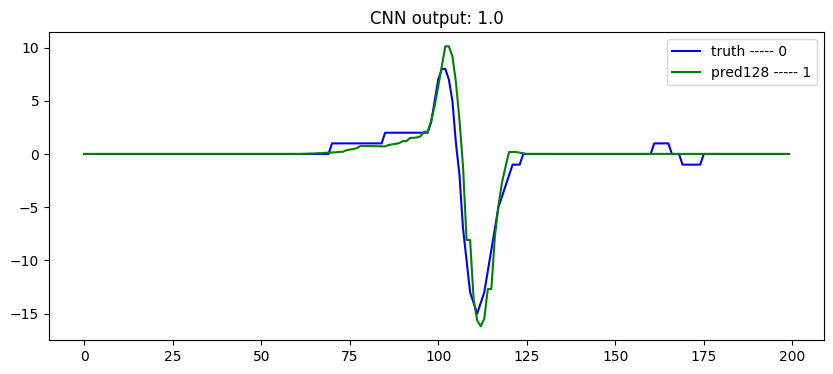

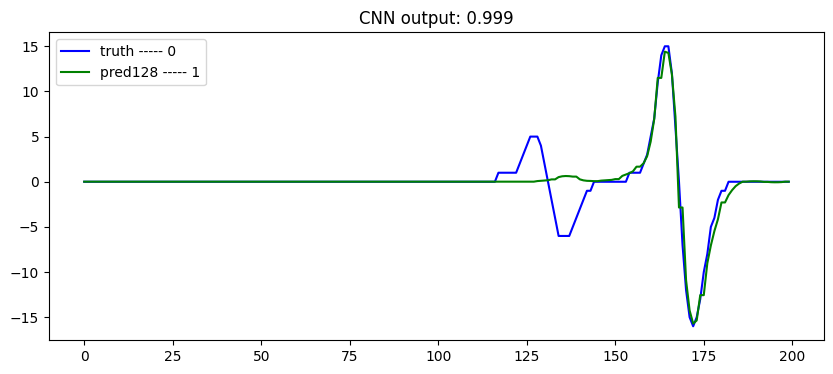

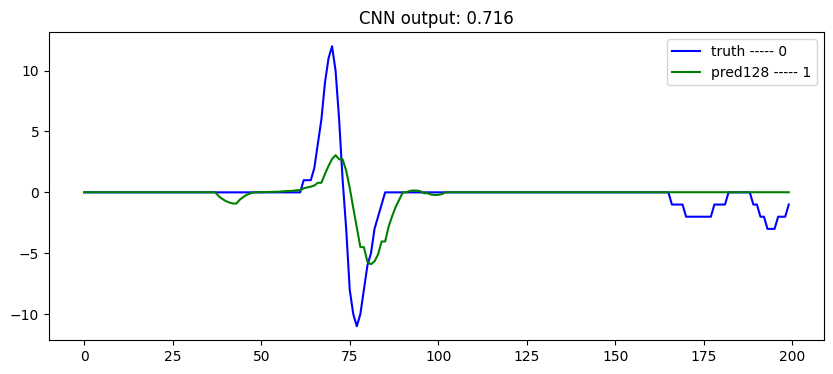

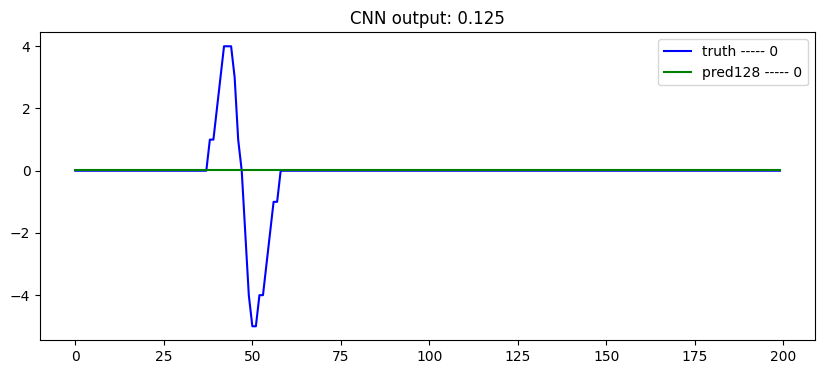

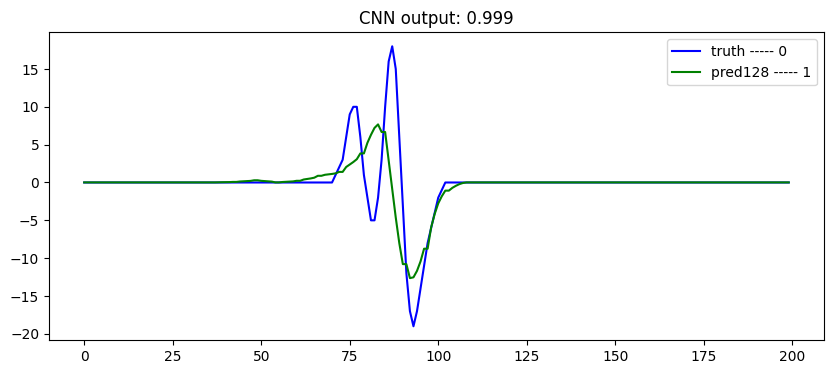

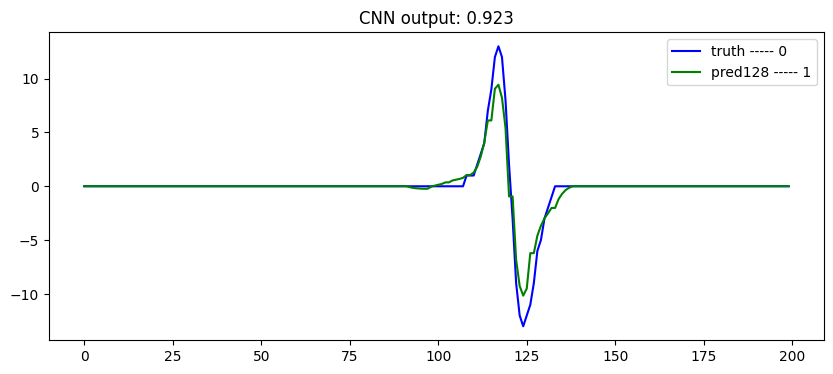

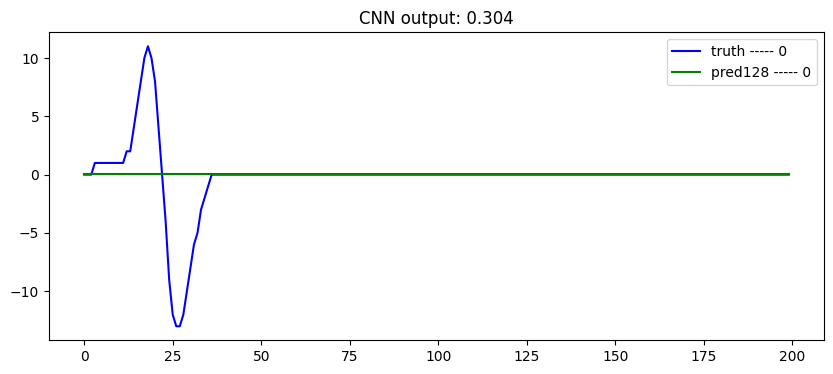

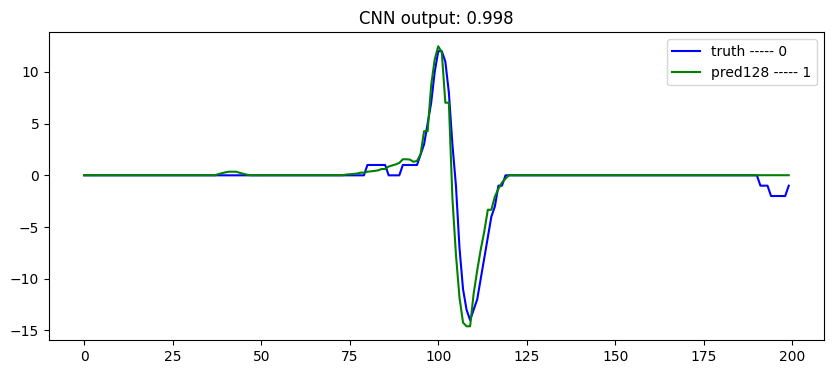

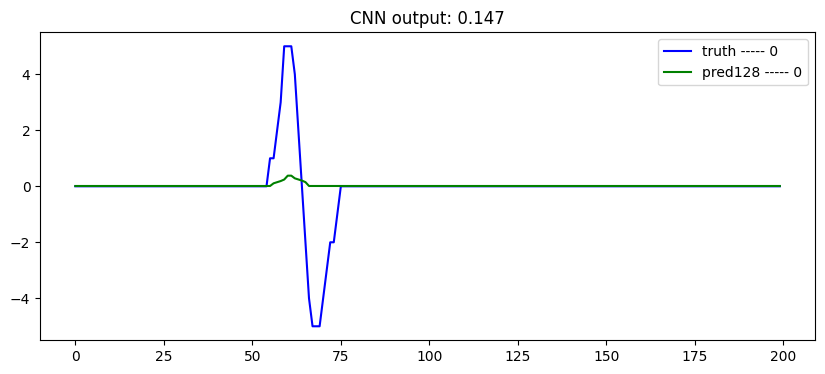

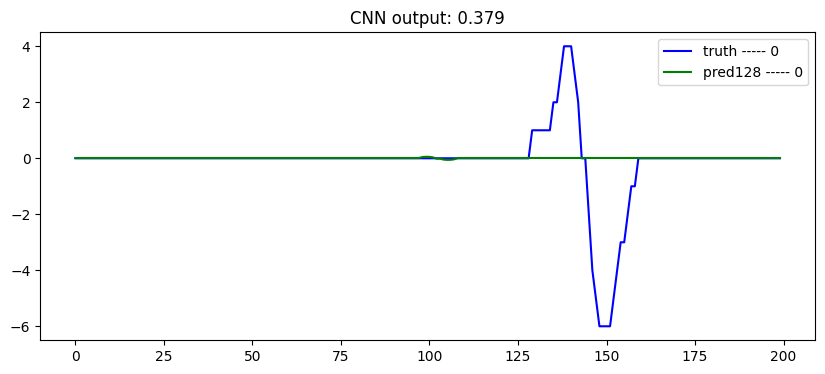

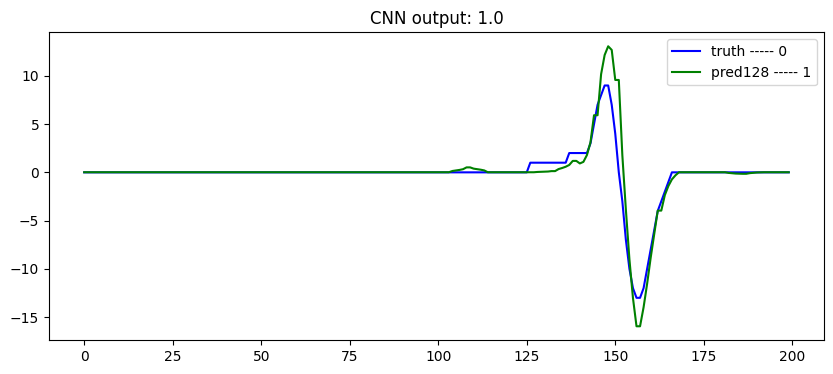

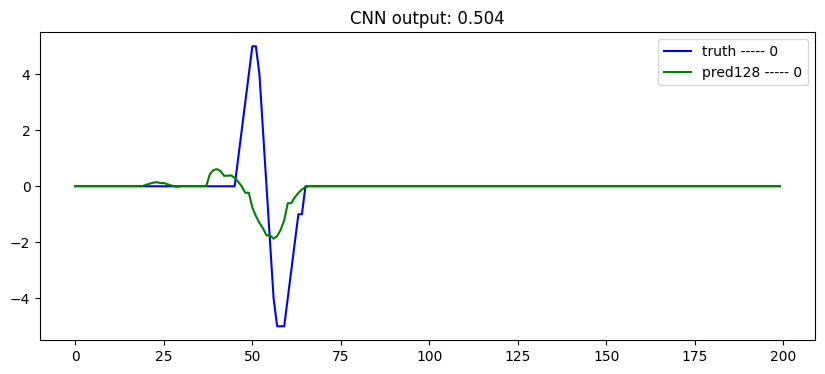

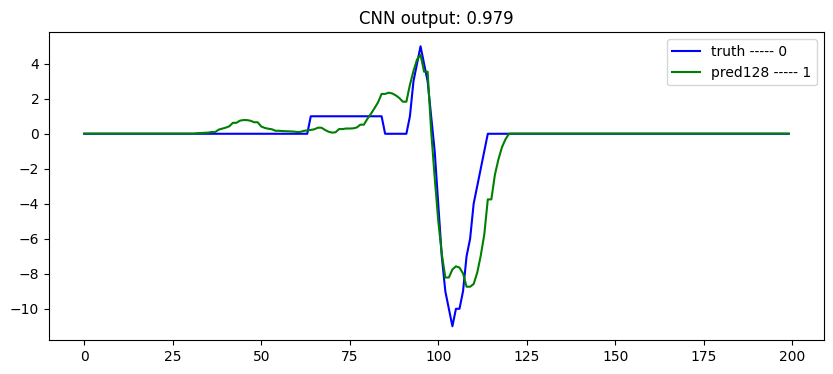

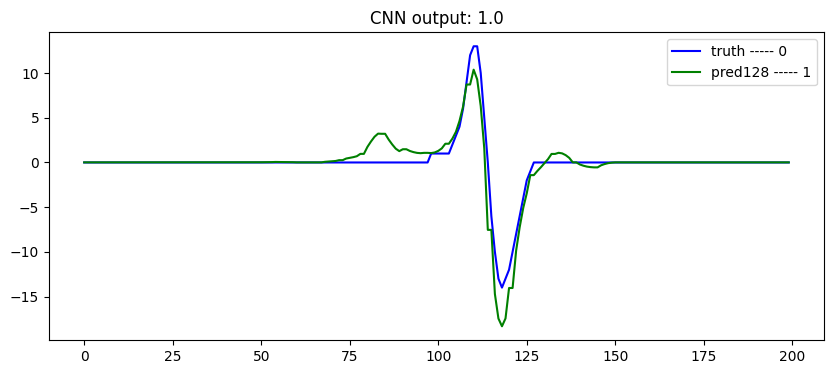

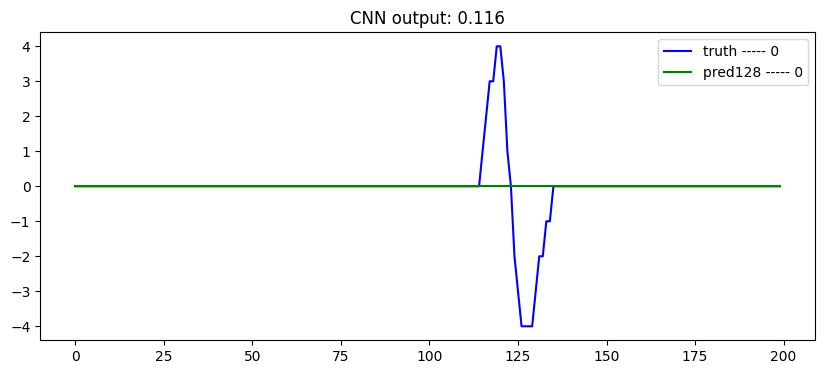

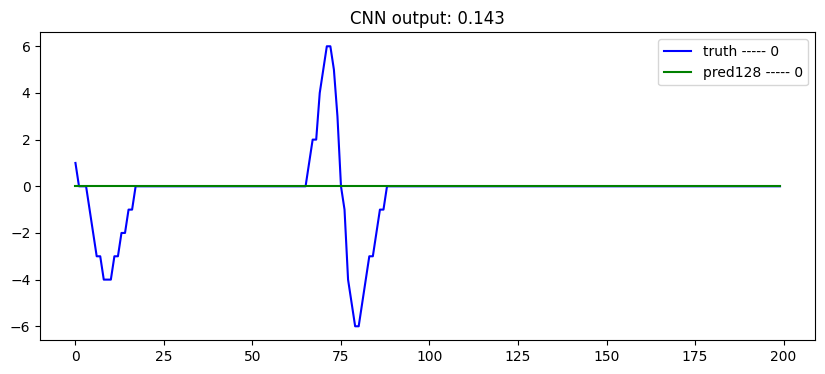

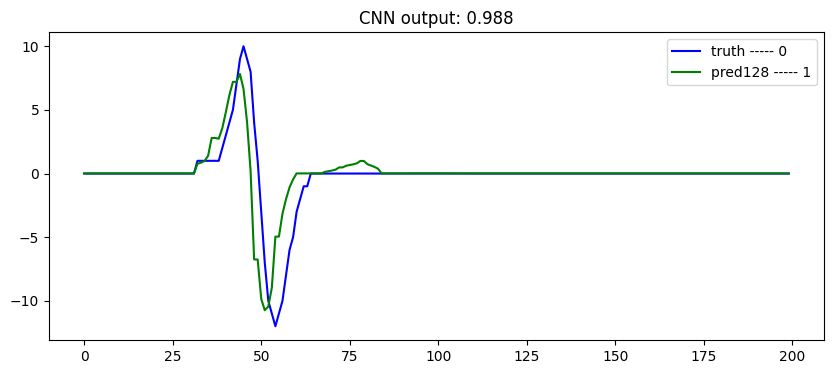

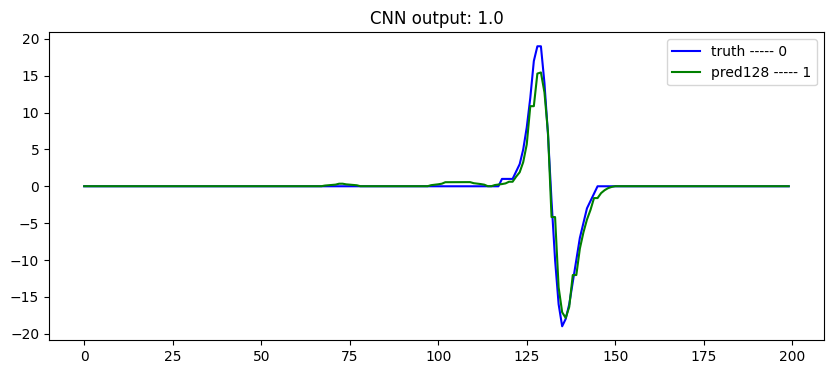

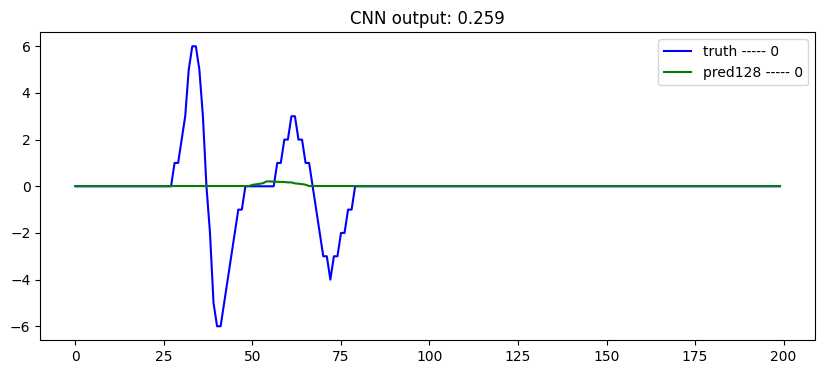

In [44]:
for i in range(100):
    if max(abs(y_test_[i])) < 20 and sum(abs(y_test_[i])) !=0:
        fig = plt.figure(figsize=(10,4))
        plt.plot(y_test_[i], color='blue', label='truth ----- ' + str(truth_labels[i]))
        plt.plot(pred128[i], color='green', label='pred128 ----- ' + str(pred_labels128[i]))
        #plt.plot(pred128_cmse[i], color='m', label='pred128_cmse ----- ' + str(pred_labels128[i]))
        #plt.plot(pred256[i], color='orange', label='pred256 ----- ' + str(pred_labels256[i]))
        #plt.plot(pred512[i], color='purple', label='pred512 ----- ' + str(pred_labels512[i]))
        #plt.plot(pred1024[i], color='red', label='pred1024 ----- ' + str(pred_labels1024[i]))
        plt.title('CNN output: ' + str( round(cnn_pred[i], 3)))
        plt.legend()
        plt.show()


In [45]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr128, tpr128, thresholds128 = roc_curve(truth_labels, pred_labels128, drop_intermediate=False)
roc_auc128 = auc(fpr128, tpr128)

#fpr128_cmse, tpr128_cmse, thresholds128_cmse = roc_curve(truth_labels, pred_labels128_cmse, drop_intermediate=False)
#roc_auc128_cmse = auc(fpr128_cmse, tpr128_cmse)

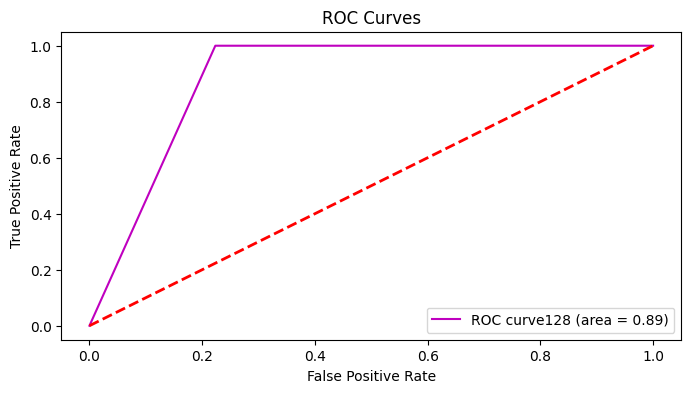

In [46]:
fig = plt.figure(figsize=(8, 4))
plt.plot(fpr128, tpr128, color='m', label='ROC curve128 (area = %0.2f)' % roc_auc128)
#plt.plot(fpr128_cmse, tpr128_cmse, color='g', label='ROC curve128_cmse (area = %0.2f)' % roc_auc128_cmse)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [51]:
def make_single_pdf(wave_idx, pg_num, min_cnn, max_cnn):

    fig, axs = plt.subplots(3,2, figsize=(30, 18), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .375, wspace=.1)

    axes = axs.ravel()

    for i in range(6):
        index_ = i + wave_idx
        max_adc = int((max(x_test_[index_])))
        
        if not (max_adc < 20 and cnn_pred[index_] > min_cnn and cnn_pred[index_] <= max_cnn and sum(abs(y_test_[index_])) != 0):
            while True:
                index_ += 1
                max_adc = int((max(x_test_[index_])))
                
                if (max_adc < 20 and cnn_pred[index_] > min_cnn and cnn_pred[index_] <= max_cnn and sum(abs(y_test_[index_])) != 0):
                    break
        wave_idx = index_


        axes[i].plot(x_test_[index_], color='black',alpha=0.2, label = 'original input (adc_max: ' + str(max_adc) + ')')
        axes[i].plot(y_test_[index_],color='blue', label='target', alpha=1)
        axes[i].plot(pred128[index_], color='m', label='model_128  ---   ' + str(pred_labels128[index_]))
        #axes[i].plot(pred128_cmse[index_], color='green', label='model_128_cmse  ---   ' + str(pred_labels128_cmse[index_]))
        axes[i].legend(fontsize=12)
        axes[i].set_title('CNN output: ' + str(round(cnn_pred[index_], 4)) + ' --- [idx: ' + str(index_) + ']', size=15)
        axes[i].set_ylabel('ADC', size=12)


    plt.savefig('./TEST/pdfs/tmp_plts/plts_cnn_page' + str(pg_num) +  '.pdf',
                dpi=300,
                bbox_inches='tight', pad_inches=0.75)
    plt.close()

    return wave_idx

In [52]:
# creates and merges pdf, removes all single page pdfs from tmp folder
def make_complete_pdf(num_pages, min_cnn, max_cnn):
    wave_idx_ = 0
    page_num = 0

    while page_num < num_pages:
        wave_idx_ = make_single_pdf(wave_idx_, page_num, min_cnn, max_cnn) + 1
        page_num += 1

    merger = PdfMerger()
    path = './TEST/pdfs/tmp_plts/'
    pdf_files = [path+f for f in listdir(path) if (isfile(join(path, f)))]
    print(pdf_files)
    for pdf_file in pdf_files:
        #Append PDF files
        merger.append(pdf_file)
    #merger.write('pdfs/plts_tmp/plts_' + wireplane + '_cnn_'+str(int(min_cnn*100)) + '-' + str(int(max_cnn*100)) + '_' + str(num_pages) +  'pages.pdf')
    merger.write('./TEST/pdfs/'+wireplane+'/plts_' + wireplane + '_cnn_'+str(int(min_cnn*100)) + '-' + str(int(max_cnn*100)) + '_' + str(num_pages) +  'pages.pdf')
    merger.close()

    for file in pdf_files:
        os.remove(file)

In [53]:
make_complete_pdf(10, 0.94, 1)

['./TEST/pdfs/tmp_plts/plts_cnn_page2.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page6.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page1.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page8.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page9.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page5.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page7.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page0.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page4.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page3.pdf']


In [54]:
min_ = 0.94
prev = min_
max_ = 1
while min_ > 0:
    min_ = min_ - 0.2 
    make_complete_pdf(10, min_, prev)
    prev = min_


['./TEST/pdfs/tmp_plts/plts_cnn_page2.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page6.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page1.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page8.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page9.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page5.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page7.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page0.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page4.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page3.pdf']
['./TEST/pdfs/tmp_plts/plts_cnn_page2.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page6.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page1.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page8.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page9.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page5.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page7.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page0.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page4.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page3.pdf']
['./TEST/pdfs/tmp_plts/plts_cnn_page2.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page6.pdf', './TEST/pdfs/tmp_plts/plts_cnn_page1.pdf', './TEST/

: 